<a href="https://colab.research.google.com/github/gandhisamay/Segmentation/blob/main/Semantic_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

  Created wheel for gputil: filename=GPUtil-1.4.0-cp37-none-any.whl size=7411 sha256=98c3556842b304515bce4ff9eac5b34397f6abab94b8fbfe407563775ed44789
  Stored in directory: /root/.cache/pip/wheels/3d/77/07/80562de4bb0786e5ea186911a2c831fdd0018bda69beab71fd
Successfully built gputil
Gen RAM Free: 12.7 GB  | Proc size: 118.6 MB
GPU RAM Free: 15109MB | Used: 0MB | Util   0% | Total 15109MB


In [1]:
%cd '/content/drive/MyDrive/Datasets /cityscapes_data'

/content/drive/MyDrive/Datasets /cityscapes_data


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import torch 
import torch.nn as nn 
from torch.utils.data import DataLoader,Dataset 
from torchvision import transforms 
from torchvision import datasets
import torchvision.transforms.functional as TF

In [9]:
train_path = 'Train_img'
val_path   = 'Val_img'

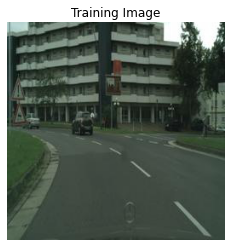

In [10]:
#Viewing Image
data = datasets.ImageFolder(train_path, transform = transforms.ToTensor())
img = data[0][0]
plt.title('Training Image')
plt.axis("off")
plt.imshow(img[:,:,:256].permute(1,2,0))

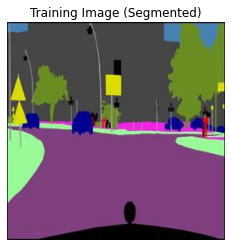

In [11]:
img = data[0][0]
plt.title('Training Image (Segmented)')
plt.axis("off")
plt.imshow(img[:,:,256:].permute(1,2,0))

In [12]:
#Making the dataset
class CityScapeDataset(Dataset):
    def __init__(self,path):
        #Define the transforms
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(0.5,0.5)
        ])
        
        #Make the train and val datasets and apply the transforms
        dataset = datasets.ImageFolder(path, transform = transform)
        
        self.dataset = dataset
        
    def __getitem__(self,index):
            return self.dataset[index][0][:,:,:256],self.dataset[index][0][:,:,256:]
     
    def __len__(self):
        return len(self.dataset)

In [13]:
train_dataset = CityScapeDataset(train_path)
test_dataset = CityScapeDataset(val_path)

In [14]:
len(train_dataset)

2975

In [15]:
train_dataset[0][0]

tensor([[[ 0.4118,  0.3882, -0.0275,  ..., -0.7882, -0.7333, -0.8118],
         [ 0.4039,  0.3882, -0.0275,  ..., -0.5765, -0.7961, -0.6392],
         [ 0.3804,  0.3725, -0.0353,  ..., -0.7412, -0.8431, -0.7020],
         ...,
         [-0.3412, -0.3412, -0.3412,  ..., -0.5686, -0.5686, -0.5686],
         [-0.3569, -0.3490, -0.3490,  ..., -0.5686, -0.5686, -0.5686],
         [-0.3647, -0.3569, -0.3569,  ..., -0.5686, -0.5686, -0.5686]],

        [[ 0.6235,  0.6000,  0.1843,  ..., -0.6627, -0.5922, -0.6706],
         [ 0.6157,  0.6000,  0.1843,  ..., -0.4510, -0.6549, -0.4980],
         [ 0.6078,  0.6000,  0.1922,  ..., -0.6157, -0.7020, -0.5608],
         ...,
         [-0.1922, -0.1922, -0.1922,  ..., -0.4431, -0.4431, -0.4431],
         [-0.2078, -0.2000, -0.2000,  ..., -0.4431, -0.4431, -0.4431],
         [-0.2157, -0.2078, -0.2078,  ..., -0.4431, -0.4431, -0.4431]],

        [[ 0.5843,  0.5608,  0.1451,  ..., -0.7412, -0.6863, -0.7647],
         [ 0.5765,  0.5608,  0.1451,  ..., -0

In [16]:
#Make the data_loader now so that the data is ready for training
batch_size = 32 

train_loader = DataLoader(train_dataset,batch_size)
test_loader  = DataLoader(test_dataset,batch_size*2)

In [17]:
#Define the CNN block now
#Defined as per the U-net Structure 
#Made some modifications too to the original structure
class DoubleCNNBlock(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(
            out_channels
        )
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=out_channels,
            out_channels=out_channels,
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(
            out_channels
        )
        self.act2 = nn.ReLU() 
    def forward(self,x):
        out = self.act1(self.bn1(self.conv1(x)))
        out = self.act2(self.bn2(self.conv2(out)))
        return out

In [18]:
class UpConv(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.tconv = nn.ConvTranspose2d(
            in_channels=in_channels,
            out_channels=out_channels,
            kernel_size=2,
            stride=2
        ) 

    def forward(self,x,skip_connection):
        out = self.tconv(x)
        if out.shape != skip_connection.shape:
            print("1")
            out = TF.resize(out ,size=skip_connection.shape[2:])
        out = torch.cat([skip_connection,out],axis = 1)
        return out

In [19]:
class Bottom(nn.Module):
    def __init__(self,channels_bottom=[512,1024]):
        super().__init__()
        self.channels_bottom = channels_bottom
        self.conv1 = nn.Conv2d(
            in_channels=512,
            out_channels=1024,
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn1 = nn.BatchNorm2d(
            self.channels_bottom[1]
        )
        self.act1 = nn.ReLU()
        self.conv2 = nn.Conv2d(
            in_channels=self.channels_bottom[1],
            out_channels=self.channels_bottom[1],
            kernel_size=3,
            padding=1,
            stride=1,
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(
            self.channels_bottom[1]
        )
        self.act2 = nn.ReLU()
        
        self.bottom = nn.Sequential(
            self.conv1,
            self.bn1,
            self.act1,
            self.conv2,
            self.bn2,
            self.act2
        )
    def forward(self,x):
#         out = self.act1(self.bn1(self.conv1(x)))
#         print("1:{}".format(out.shape))
#         out = self.act2(self.bn2(self.conv2(out)))
#         print("2:{}".format(out.shape))
        return self.bottom(x)

In [20]:
class Unet(nn.Module):
    def __init__(self,num_classes,filters=[64,128,256,512],input_channels=3):
        super().__init__()
        self.contract = nn.ModuleList()
        self.expand   = nn.ModuleList()                      #64 - #128 - #256 - #512 - #1024 -#512
        self.filters  = filters
        self.input_channels = input_channels
        self.num_classes = num_classes 
        
        self.pool = nn.MaxPool2d(
            kernel_size=2,
            stride=2
        )
        
        for filters in self.filters:
            self.contract.append(
                DoubleCNNBlock(
                    in_channels=input_channels,
                    out_channels=filters
                )
            )
            input_channels = filters
            
        for filters in reversed(self.filters):
            self.expand.append(
                UpConv(
                    in_channels=filters*2,
                    out_channels=filters
                )
            )
            self.expand.append(
                DoubleCNNBlock(
                    in_channels=filters*2,
                    out_channels=filters
                )
            )
            
        self.final = nn.Conv2d(
                    in_channels=self.filters[0],
                    out_channels=num_classes,
                    kernel_size=3,
                    padding=1,
                    stride=1
                    )
            
    def forward(self,x):
        skip_connections = []
        
        for downs in self.contract:
            out = downs(x)
            skip_connections.append(out)
            out   = self.pool(out)
            x = out
        
        bottom = Bottom()
        bottom.to('cuda')
        y = bottom(x)
        
        for idx in range(0,len(self.expand),2):
            skip_connection = skip_connections[len(skip_connections)-idx//2-1]
            y = self.expand[idx](y,skip_connection)
            y = self.expand[idx+1](y)
            
        return self.final(y)

In [21]:
model = Unet(num_classes=30)
model.to('cuda')

Unet(
  (contract): ModuleList(
    (0): DoubleCNNBlock(
      (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
    )
    (1): DoubleCNNBlock(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU()
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act2): ReLU()
    )
    (2): DoubleCNNBlock(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3

In [23]:
x = torch.randn((3,3,256,256), device ='cuda')

In [24]:
model(x)

tensor([[[[-5.1355e-02, -2.4481e-01, -6.6005e-03,  ..., -7.0506e-02,
            3.6820e-02,  8.7001e-03],
          [ 5.8629e-02, -3.9752e-01, -1.5529e-02,  ..., -9.6719e-03,
           -9.7732e-02,  7.7173e-02],
          [-1.4197e-01,  1.2076e-01,  6.4106e-01,  ..., -4.8633e-01,
           -7.1914e-01, -9.4885e-02],
          ...,
          [ 3.6517e-01, -7.2025e-01,  4.6012e-01,  ..., -2.6684e-01,
           -4.6515e-01, -6.3637e-01],
          [-3.6519e-01, -4.7946e-01, -8.2800e-01,  ..., -7.2675e-01,
           -6.6726e-01,  6.7626e-02],
          [-2.1298e-01, -7.1102e-02,  1.0862e-01,  ..., -4.2969e-02,
           -6.5995e-01,  1.3949e-01]],

         [[ 1.9858e-01,  4.2392e-02,  1.3567e-01,  ..., -1.9770e-02,
            5.9838e-02, -2.5218e-02],
          [ 3.0179e-01,  3.8734e-01,  9.9405e-02,  ...,  3.2023e-02,
            1.3506e-01,  1.5019e-01],
          [ 1.0783e-01,  3.4937e-01, -2.9396e-01,  ...,  1.0335e-01,
           -1.0092e-01,  1.1615e-01],
          ...,
     